(lgm-prelims-notebook)=
# Dati longitudinali 

In [72]:
source("../_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("semPlot")
    library("knitr")
    library("markdown")
    library("kableExtra")
})
set.seed(42)

## Aggiungere una Componente Longitudinale ad un Modello CFA

Per esplorare le peculiarità di un modello di misurazione longitudinale, prenderemo in esame un modello CFA (Confirmatory Factor Analysis) che impiega tre indicatori per misurare lo stesso costrutto latente in due distinte occasioni temporali.

Al centro di ogni modello SEM troviamo l'equazione fondamentale espressa come segue in LaTeX:

$$ \Sigma = \Lambda \Psi \Lambda' + \Theta, $$

dove:
- $ \Sigma $ rappresenta la matrice delle varianze e covarianze dedotte dal modello.
- $ \Lambda $ indica la matrice dei carichi fattoriali, che descrive le relazioni tra gli indicatori e i costrutti.
- $ \Psi $ è la matrice che esprime le varianze e covarianze intercorrenti tra i costrutti.
- $ \Theta $ si riferisce alla matrice delle varianze residue, ovvero quei fattori unici, e alle covarianze residue tra gli indicatori.

Un elemento distintivo dei modelli longitudinali è la possibilità di correlare le varianze residue degli stessi indicatori misurati in momenti differenti (per esempio, la correlazione tra Y1 al Tempo 1 e Y1 al Tempo 2). Tale approccio consente di identificare non solo le informazioni condivise dal costrutto attraverso il tempo, ma anche quelle peculiari e specifiche di ogni singolo indicatore in ciascun momento osservato.

Questo modello SEM longitudinale fornisce un mezzo per esaminare come un costrutto latente e i suoi indicatori si sviluppino o cambino nel tempo, tenendo conto sia delle variazioni comuni al costrutto sia di quelle specifiche a ciascun indicatore in diversi momenti.

Applichiamo questo modello all'esempio discusso da {cite:t}`little2023longitudinal`: tre indicatori di Positive Affect (Glad, Cheerful, Happy) vengono misurati in due momenti del tempo.

In [2]:
dat <- read.table(
    file = "../data/grade7and8.long.823.dat",
    col.names = c(
        "PAT1P1", "PAT1P2", "PAT1P3", "NAT1P1", "NAT1P2", "NAT1P3",
        "PAT2P1", "PAT2P2", "PAT2P3", "NAT2P1", "NAT2P2", "NAT2P3",
        "PAT3P1", "PAT3P2", "PAT3P3", "NAT3P1", "NAT3P2", "NAT3P3",
        "grade", "female", "black", "hispanic", "other"
    )
)
glimpse(dat)

Rows: 823
Columns: 23
$ PAT1P1   <dbl> 1.50000, 2.98116, 3.50000, 3.00000, 3.00000, 3.00000, 3.00000~
$ PAT1P2   <dbl> 1.50000, 2.98284, 4.00000, 3.50000, 2.50000, 2.50000, 2.50000~
$ PAT1P3   <dbl> 2.00000, 2.98883, 4.00000, 2.50000, 3.00000, 3.00000, 4.00000~
$ NAT1P1   <dbl> 2.50000, 1.56218, 1.50000, 1.50000, 1.00000, 1.50000, 1.00000~
$ NAT1P2   <dbl> 3.50000, 1.45688, 1.00000, 2.00000, 1.00000, 2.50000, 1.00000~
$ NAT1P3   <dbl> 3.00000, 1.65477, 1.00000, 1.50000, 1.00000, 2.50000, 1.00000~
$ PAT2P1   <dbl> 4.00000, 4.00000, 4.00000, 2.95942, 3.17170, 2.00000, 3.00000~
$ PAT2P2   <dbl> 4.00000, 4.00000, 2.50000, 2.99083, 2.87806, 2.00000, 3.00000~
$ PAT2P3   <dbl> 4.00000, 4.00000, 4.00000, 3.06670, 3.11031, 3.00000, 4.00000~
$ NAT2P1   <dbl> 2.00000, 1.00000, 1.00000, 1.65159, 1.65777, 2.00000, 1.00000~
$ NAT2P2   <dbl> 1.00000, 1.00000, 1.00000, 1.42599, 1.44804, 2.00000, 1.00000~
$ NAT2P3   <dbl> 2.00000, 1.00000, 1.00000, 1.67184, 1.56296, 2.00000, 1.00000~
$ PAT3P1   <dbl> 4

Il modello SEM longitudinale per questi dati è simile ad un modello CFA per un solo momento del tempo. Ci sono i fattori che vengono identificati dagli indicatori misurati nei due momenti del tempo (Fattore T1 e Fattore T2). Tali fattori sono correlati. Inoltre, risultano correlati anche i fattori specifici di ciascun indicatore nei due momenti del tempo.

In [3]:
mod_1 <- "
  # Definizione dei fattori latenti al tempo T1
  Fattore_T1 =~ NA*PAT1P1 + PAT1P2 + PAT1P3

  # Definizione dei fattori latenti al tempo T2
  Fattore_T2 =~ NA*PAT2P1 + PAT2P2 + PAT2P3

  # Varianza dei fattori latenti
  Fattore_T1 ~~ 1*Fattore_T1
  Fattore_T2 ~~ 1*Fattore_T2

  # Covarianza tra i fattori latenti
  Fattore_T1 ~~ Fattore_T2

  # Definizione degli errori di misurazione per gli indicatori al tempo T1
  PAT1P1 ~~ PAT1P1
  PAT1P2 ~~ PAT1P2
  PAT1P3 ~~ PAT1P3

  # Definizione degli errori di misurazione per gli indicatori al tempo T2
  PAT2P1 ~~ PAT2P1
  PAT2P2 ~~ PAT2P2
  PAT2P3 ~~ PAT2P3

  # Covarianze tra i residui degli item tra T1 e T2
  PAT1P1 ~~ PAT2P1
  PAT1P2 ~~ PAT2P2
  PAT1P3 ~~ PAT2P3


  # Opzionale: Specifica delle medie degli indicatori (intercette)
  PAT1P1 ~ 1
  PAT1P2 ~ 1
  PAT1P3 ~ 1
  PAT2P1 ~ 1
  PAT2P2 ~ 1
  PAT2P3 ~ 1
"

Le covarianze tra gli errori degli indicatori corrispondenti tra T1 e T2 sono stimate, indicando potenziali correlazioni tra gli errori degli stessi indicatori nei due momenti temporali.

In questo modello, i carichi fattoriali e le intercettazioni non sono ancora eguagliati nel tempo, il che significa che ogni set di indicatori è libero di avere relazioni uniche con il proprio fattore latente in ciascun momento temporale.

Questo modello è definito "configural-invariant" perché mantiene la stessa struttura fattoriale (o configurazione) nel tempo, ma non impone ancora l'equivalenza dei parametri tra i due momenti temporali.

Il modello configural-invariant è spesso il punto di partenza per testare l'invarianza longitudinale in SEM, poiché stabilisce una base di confronto prima di imporre vincoli più stringenti come l'invarianza dei carichi fattoriali o delle intercette nei modelli successivi.

Adattiamo il modello ai dati.

In [4]:
fit_1 <- lavaan::sem(mod_1, data = dat, meanstructure = TRUE)

In [5]:
parameterEstimates(fit_1) |> print()

lhs,op,rhs,est.std,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Fattore_T1,=~,PAT1P1,0.87702996,0.011231481,78.0867596,0.00000000,0.855016665,0.8990433
Fattore_T1,=~,PAT1P2,0.88467531,0.010965490,80.6781351,0.00000000,0.863183341,0.9061673
Fattore_T1,=~,PAT1P3,0.86044422,0.011905474,72.2729928,0.00000000,0.837109921,0.8837785
Fattore_T2,=~,PAT2P1,0.90688088,0.008927520,101.5826188,0.00000000,0.889383264,0.9243785
Fattore_T2,=~,PAT2P2,0.90830344,0.008892536,102.1422261,0.00000000,0.890874389,0.9257325
Fattore_T2,=~,PAT2P3,0.87477274,0.010308914,84.8559541,0.00000000,0.854567643,0.8949778
Fattore_T1,~~,Fattore_T1,1.00000000,0.000000000,NA,NA,1.000000000,1.0000000
Fattore_T2,~~,Fattore_T2,1.00000000,0.000000000,NA,NA,1.000000000,1.0000000
Fattore_T1,~~,Fattore_T2,0.55204658,0.027409764,20.1405085,0.00000000,0.498324434,0.6057687


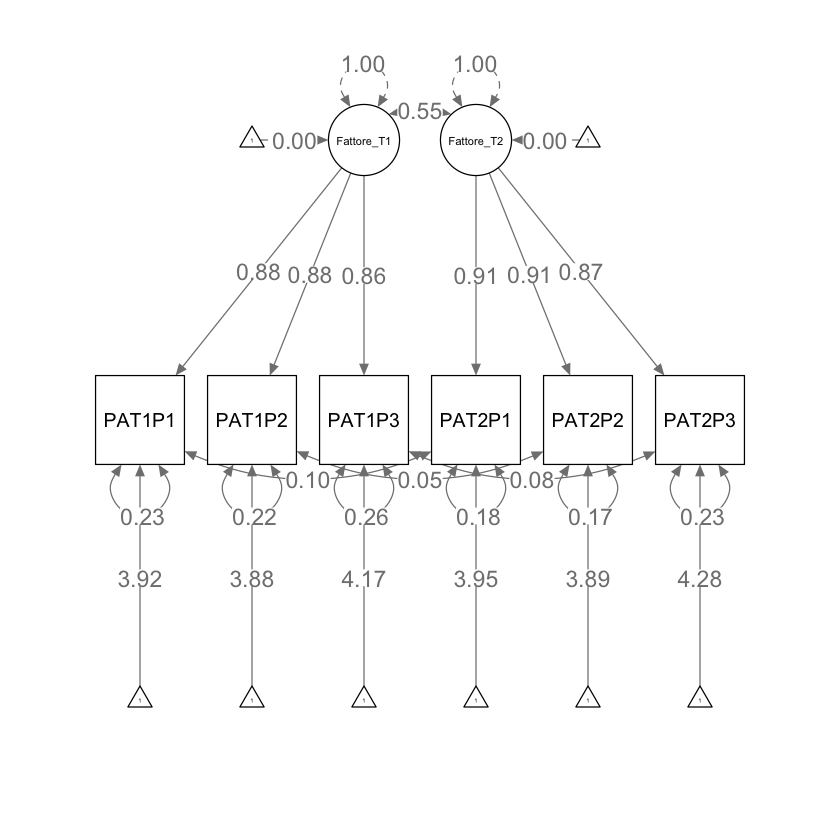

In [6]:
semPaths(fit_1,
    whatLabels = "std",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

In [7]:
fitMeasures(fit_1, c("cfi", "tli", "rmsea", "srmr")) |> print()

  cfi   tli rmsea  srmr 
1.000 0.999 0.016 0.010 


Potremmo pensare che modello di baseline (con cui possono essere confrontati i modello che descrivono il cambiamento temporale) sia semplicemente il modello in cui non sono permesse covarianze.

In [9]:
mod_2 <- "
  # Definizione dei fattori latenti al tempo T1
  Fattore_T1 =~ NA*PAT1P1 + PAT1P2 + PAT1P3

  # Definizione dei fattori latenti al tempo T2
  Fattore_T2 =~ NA*PAT2P1 + PAT2P2 + PAT2P3

  # Varianza dei fattori latenti
  Fattore_T1 ~~ 1*Fattore_T1
  Fattore_T2 ~~ 1*Fattore_T2

  # Covarianza tra i fattori latenti
  Fattore_T1 ~~ 0*Fattore_T2

  # Definizione degli errori di misurazione per gli indicatori al tempo T1
  PAT1P1 ~~ PAT1P1
  PAT1P2 ~~ PAT1P2
  PAT1P3 ~~ PAT1P3

  # Definizione degli errori di misurazione per gli indicatori al tempo T2
  PAT2P1 ~~ PAT2P1
  PAT2P2 ~~ PAT2P2
  PAT2P3 ~~ PAT2P3

  # Covarianze tra i residui degli item tra T1 e T2
  # PAT1P1 ~~ PAT2P1
  # PAT1P2 ~~ PAT2P2
  # PAT1P3 ~~ PAT2P3

  # Opzionale: Specifica delle medie degli indicatori (intercette)
  PAT1P1 ~ 1
  PAT1P2 ~ 1
  PAT1P3 ~ 1
  PAT2P1 ~ 1
  PAT2P2 ~ 1
  PAT2P3 ~ 1
"

In [10]:
fit_2 <- lavaan::sem(mod_2, data = dat, meanstructure = TRUE)

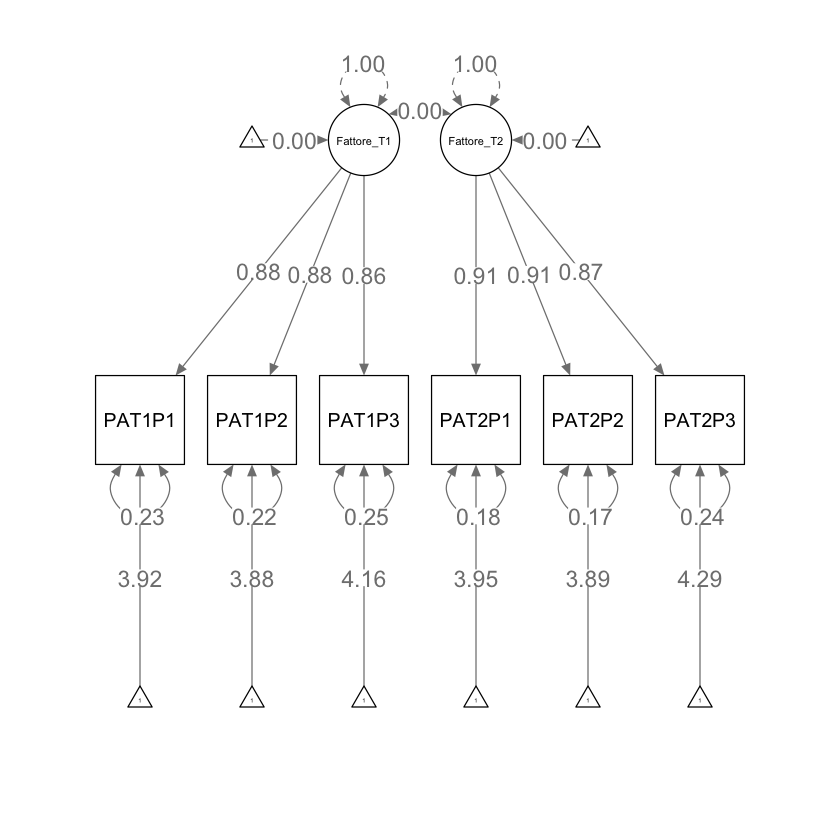

In [11]:
semPaths(fit_2,
    whatLabels = "std",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

In [12]:
parameterEstimates(fit_2) |> print()

lhs,op,rhs,est.std,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Fattore_T1,=~,PAT1P1,0.8767791,0.011470104,76.44038,0,0.8542981,0.8992601
Fattore_T1,=~,PAT1P2,0.8810370,0.011316951,77.85109,0,0.8588562,0.9032178
Fattore_T1,=~,PAT1P3,0.8649101,0.011912582,72.60475,0,0.8415619,0.8882583
Fattore_T2,=~,PAT2P1,0.9071732,0.009082626,99.88006,0,0.8893716,0.9249749
Fattore_T2,=~,PAT2P2,0.9098512,0.008982875,101.28730,0,0.8922450,0.9274573
Fattore_T2,=~,PAT2P3,0.8723262,0.010511810,82.98535,0,0.8517235,0.8929290
Fattore_T1,~~,Fattore_T1,1.0000000,0.000000000,NA,NA,1.0000000,1.0000000
Fattore_T2,~~,Fattore_T2,1.0000000,0.000000000,NA,NA,1.0000000,1.0000000
Fattore_T1,~~,Fattore_T2,0.0000000,0.000000000,NA,NA,0.0000000,0.0000000


In [13]:
fitMeasures(fit_2, c("cfi", "tli", "rmsea", "srmr")) |> print()

  cfi   tli rmsea  srmr 
0.931 0.886 0.187 0.253 


In realtà, come sottolineato da {cite:t}`little2023longitudinal`, nel contesto dei disegni longitudinali, il modello di base appropriato prevede che vengano aggiunte al modello nullo delle aspettative aggiuntive, specificatamente che le medie e le varianze rimangano invariate nel tempo. Questa specificazione ampliata del modello nullo fornisce il confronto appropriato per analizzare e interpretare i dati longitudinali.

In [14]:
mod_3 <- "
  # Definizione dei fattori latenti al tempo T1
  Fattore_T1 =~ NA*PAT1P1 + b1*PAT1P2 + b2*PAT1P3

  # Definizione dei fattori latenti al tempo T2
  Fattore_T2 =~ NA*PAT2P1 + b1*PAT2P2 + b2*PAT2P3

  # Varianza dei fattori latenti
  Fattore_T1 ~~ c1*Fattore_T1
  Fattore_T2 ~~ c1*Fattore_T2

  # Covarianza tra i fattori latenti (assumendo che sia 0)
  Fattore_T1 ~~ 0*Fattore_T2

  # Definizione degli errori di misurazione per gli indicatori al tempo T1
  PAT1P1 ~~ a1*PAT1P1
  PAT1P2 ~~ a2*PAT1P2
  PAT1P3 ~~ a3*PAT1P3

  # Definizione degli errori di misurazione per gli indicatori al tempo T2
  PAT2P1 ~~ a1*PAT2P1
  PAT2P2 ~~ a2*PAT2P2
  PAT2P3 ~~ a3*PAT2P3

  # Specifica delle medie degli indicatori (intercettazioni) uguali tra i due tempi
  # PAT1P1 ~ m1
  # PAT1P2 ~ m2
  # PAT1P3 ~ m3
  # PAT2P1 ~ m1
  # PAT2P2 ~ m2
  # PAT2P3 ~ m3
"

In [15]:
fit_3 <- lavaan::sem(mod_3, data = dat, meanstructure = TRUE)

Warning message in lav_model_vcov(lavmodel = lavmodel, lavsamplestats = lavsamplestats, :
"lavaan WARNING:
    The variance-covariance matrix of the estimated parameters (vcov)
    does not appear to be positive definite! The smallest eigenvalue
    (= 4.083534e-17) is close to zero. This may be a symptom that the
    model is not identified."


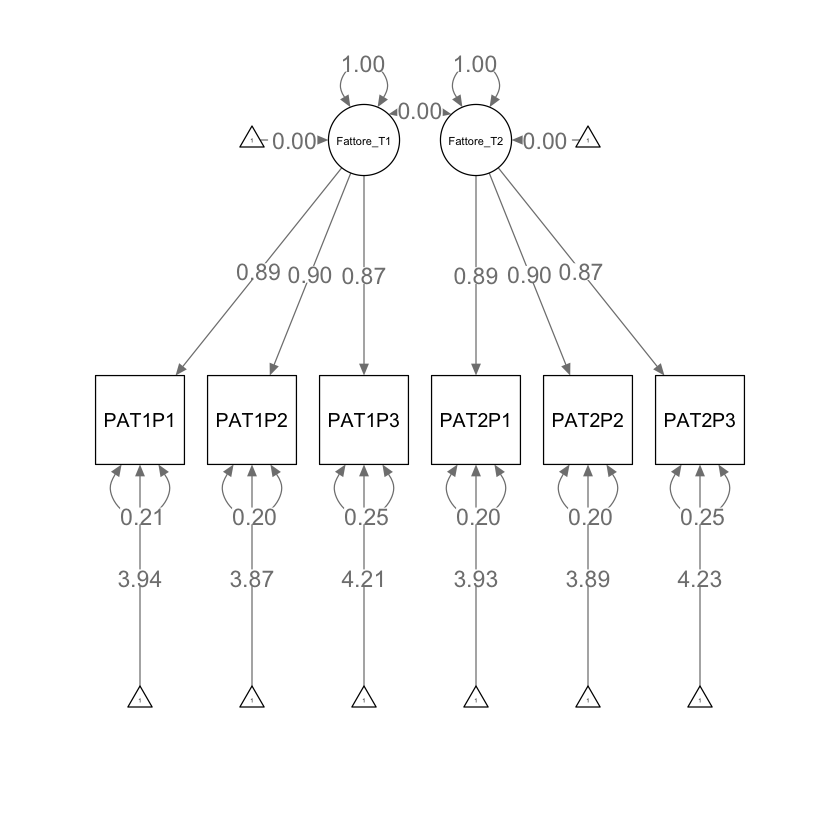

In [16]:
semPaths(fit_3,
    whatLabels = "std",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

In [25]:
parameterEstimates(fit_3) |> print()

,lhs,op,rhs,label,est,se,z,pvalue,ci.lower,ci.upper
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Fattore_T1,=~,PAT1P1,,0.8629717,0.018080386,47.72972,0,0.82753481,0.8984086
2,Fattore_T1,=~,PAT1P2,b1,0.8542991,0.011870579,71.96777,0,0.83103318,0.8775650
3,Fattore_T1,=~,PAT1P3,b2,0.8180614,0.012342194,66.28168,0,0.79387113,0.8422516
4,Fattore_T2,=~,PAT2P1,,0.8705684,0.018092517,48.11759,0,0.83510773,0.9060291
5,Fattore_T2,=~,PAT2P2,b1,0.8542991,0.011870579,71.96777,0,0.83103318,0.8775650
6,Fattore_T2,=~,PAT2P3,b2,0.8180614,0.012342194,66.28168,0,0.79387113,0.8422516
7,Fattore_T1,~~,Fattore_T1,c1,0.6144110,0.013755521,44.66650,0,0.58745070,0.6413714
8,Fattore_T2,~~,Fattore_T2,c1,0.6144110,0.013755521,44.66650,0,0.58745070,0.6413714
9,Fattore_T1,~~,Fattore_T2,,0.0000000,0.000000000,NA,NA,0.00000000,0.0000000


In [26]:
fitMeasures(fit_3, c("cfi", "tli", "rmsea", "srmr")) |> print()

  cfi   tli rmsea  srmr 
0.927 0.916 0.160 0.254 


In [27]:
lavTestLRT(fit_1, fit_3) |> print()

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
fit_1,5,7427.758,7531.443,6.064518,NA,NA,NA,NA
fit_3,13,7693.501,7759.483,287.807829,281.7433,0.2039045,8,3.146429e-56


## Invarianza Fattoriale Longitudinale

Qualsiasi confronto degli stessi costrutti nel tempo o tra gruppi presuppone che le misurazioni siano invarianti a livello fattoriale. Una delle principali forze della SEM (Structural Equation Modeling) è la possibilità di testare questa ipotesi. L'invarianza fattoriale è probabilmente la questione empirica più importante da affrontare in qualsiasi analisi che coinvolga più di un gruppo e/o più di un punto temporale.

L'invarianza di misurazione si riferisce alla capacità dello strumento di misurazione di rilevare lo stesso costrutto nella stessa metrica in ogni occasione di misurazione, garantendo la comparabilità dei punteggi tra le diverse occasioni e le diverse persone. Ad esempio, se si utilizza una bilancia per misurare il peso degli individui, è importante utilizzare la stessa bilancia tarata nello stesso modo in ogni occasione di misurazione per garantire l'invarianza di misurazione. Se non si garantisce l'invarianza di misurazione, i punteggi risultanti non saranno confrontabili quantitativamente e lo strumento di misurazione sarà considerato non invariante.

Tuttavia, l'invarianza di misurazione può essere difficile da garantire quando si utilizzano strumenti di misurazione psicologici, poiché non è possibile tarare gli strumenti in modo simile a quanto si fa con i dispositivi fisici. In questi casi, l'invarianza di misurazione viene o assunta (il che non è ideale) o testata utilizzando modelli di misurazione formali, che consentono di valutare se gli strumenti di misurazione mantengono la stessa metrica nel tempo. Questi modelli di misurazione formali consentono di verificare l'invarianza di misurazione e garantiscono la comparabilità dei punteggi nel tempo, anche quando si utilizzano strumenti di misurazione psicologici.

Le equazioni fondamentali della SEM (Structural Equation Modeling) per i modelli longitudinali di invarianza fattoriale sono:

1. **Equazione Fondamentale per i Punteggi degli Indicatori**:
   $$ y_{io} = \tau_{o} + \Lambda_{o} \eta_{o} + \Theta_{o} $$
   Dove:
   - $ y $ rappresenta i punteggi sugli indicatori.
   - $ o $ indica l'occasione di misurazione, quindi i parametri sono stimati liberamente per ogni occasione.
   - $ i $ rappresenta la deviazione di ogni individuo dai valori previsti (cioè, varianza residua).
   - $ \tau $ è il vettore colonna delle medie degli indicatori.
   - $ \eta $ sono i punteggi del costrutto latente.
   - $ \Lambda $ è la matrice dei carichi o stime delle relazioni indicatore-costrutto.
   - $ \Theta $ è la matrice delle varianze residue o dei fattori unici e delle covarianze residue tra gli indicatori.

2. **Equazione per le Medie Previste**:
   $$ E(y_{io}) = \mu_{yo} = \tau_{o} + \Lambda_{o} \alpha_{o} $$
   Dove:
   - $ E() $ è l'operatore di aspettativa.
   - $ \mu_{y} $ è il vettore delle medie.
   - $ \alpha $ è il vettore colonna delle medie dei costrutti latenti.

3. **Matrice delle Varianze e Covarianze Implicite dal Modello**:
   $$ \Sigma_{o} = \Lambda_{o} \Psi_{o} \Lambda_{o}' + \Theta_{o} $$
   Dove:
   - $ \Sigma $ è la matrice delle varianze e covarianze implicite dal modello.
   - $ \Psi $ è la matrice delle varianze e covarianze tra i costrutti.
   - $ \Lambda' $ è la trasposta della matrice $ \Lambda $.

Nelle equazioni precedenti, la lettera "o" rappresenta le diverse occasioni di misurazione. Quando una matrice è sottoscritta con "o", significa che le stime in quella equazione sono uniche per ciascuna occasione di misurazione (stimati liberamente, senza vincoli temporali incrociati). Quando "o" non è presente, significa che le stime nella matrice sono vincolate ad essere uguali attraverso le diverse occasioni di misurazione.

### Definizione di Invarianza Fattoriale Longitudinale

Meredith (1964, 1993) ha fornito la discussione più rigorosa riguardo alle condizioni e ai modi in cui l'invarianza fattoriale può essere mantenuta. L'idea fondamentale è che se le influenze che modificano i costrutti sono espresse come influenze solo sui punteggi veri degli indicatori, allora l'invarianza fattoriale sarà rispettata. Quando solo i punteggi veri degli indicatori sono influenzati, le influenze hanno modificato solo le informazioni relative al costrutto e non le informazioni specifiche dell'indicatore. D'altra parte, se i fattori unici degli indicatori sono influenzati in modo significativo, gli indicatori non manterranno le loro relazioni relative l'uno con l'altro, e l'invarianza fattoriale non sarà supportata. In altre parole, se la varianza specifica dell'indicatore è influenzata in modo sostanziale, l'indicatore non mostrerà invarianza fattoriale.

Le dimostrazioni di Meredith mostrano che, anche sotto influenze di selezione estreme, l'invarianza fattoriale si manterrà se le varie influenze interessano solo la varianza del punteggio vero degli indicatori e non le loro varianze specifiche. Detto in un altro modo, le influenze possono interessare solo la varianza del fattore comune di un indicatore e non la sua varianza specifica unica. Nella ricerca longitudinale, età, esperienza, contesto e scelte personali sono tutti fattori che possono influenzare i cambiamenti nelle misure nel tempo. La questione chiave è se queste influenze abbiano interessato solo i punteggi veri degli indicatori e non i loro fattori unici (o almeno non di molto). Più precisamente, riconosciamo che la selezione può influenzare i fattori unici, ma se l'entità di questa influenza è trascurabile, possiamo comunque trarre conclusioni valide sulla natura dei cambiamenti longitudinali nella varianza comune tra un insieme di indicatori per un dato costrutto.

La letteratura sull'invarianza fattoriale esplora diversi livelli di invarianza, che spesso ricevono molteplici denominazioni. {cite:t}`little2023longitudinal` utilizza i termini di invarianza configurale, invarianza debole e e invarianza forte, ma talvolta utilizza anche le espressioni "invarianza dei carichi" e "invarianza delle intercette" per descrivere, rispettivamente, l'invarianza debole e forte. Inoltre, definisce l'invarianza forte come prova di comparabilità del costrutto, equivalenza di misurazione o invarianza di misurazione. Questi ultimi tre termini sono interscambiabili e indicano che qualsiasi cambiamento osservato nei costrutti nel tempo rappresenta differenze reali nel costrutto e non è dovuto a artefatti di misurazione o a pregiudizi sugli item (ad esempio, funzionamento differenziale degli item).

Per i modelli longitudinali, la questione dell'invarianza si applica solo agli indicatori e ai costrutti che sono misurati in più di un'occasione (o in più di un gruppo). Qualsiasi costrutto misurato in un solo momento temporale o in un solo gruppo non è rilevante per le equazioni definitorie. Tali costrutti isolati non verrebbero considerati nella valutazione dell'invarianza; sarebbero semplicemente costrutti non vincolati o stimati liberamente nel modello.

Le equazioni specificate di seguito e i livelli di invarianza fattoriale permettono di testare e valutare come un costrutto latente e la sua misurazione rimangano costanti o cambino nel tempo.

### Invarianza Configurale (Livello 0)

Nel livello di invarianza configurale, le relazioni fondamentali tra i costrutti e i loro indicatori sono mantenute costanti, pur consentendo variazioni nei parametri nel tempo. Le equazioni chiave per questo livello sono:
   - $ y_{o} = \tau_{o} + \Lambda_{o} \eta_{o} + \Theta_{o} $
   - $ E(y_{o}) = \mu_{yo} = \tau_{o} + \Lambda_{o} \alpha_{o} $
   - $ \Sigma_{o} = \Lambda_{o} \Psi_{o} \Lambda_{o}' + \Theta_{o} $

In questo contesto, l'invarianza configurale si concentra sull'identico schema di carichi (sia fissi che liberi) per ogni indicatore nei vari momenti temporali. Se un parametro è stimato in un momento, dovrebbe esserci una stima corrispondente nel momento successivo; se è fisso a 0 in un momento, dovrebbe essere fisso anche nell'altro. Questo livello è più qualitativo che quantitativo, valutato tramite la somiglianza visiva dei modelli e l'adattamento di base del modello. Il modello configuralmente invariante è utilizzato come base per valutare i livelli successivi di invarianza fattoriale.

### Invarianza Fattoriale Debole (Metrica) (Livello 1)

Al livello di invarianza debole, i carichi fattoriali rimangono costanti nei diversi momenti temporali, implicando una relazione stabile tra indicatori e costrutti. Le equazioni per questo livello sono:
   - $ y_{o} = \tau_{o} + \Lambda \eta_{o} + \Theta_{o} $
   - $ E(y_{o}) = \mu_{yo} = \tau_{o} + \Lambda \alpha_{o} $
   - $ \Sigma_{o} = \Lambda \Psi_{o} \Lambda' + \Theta_{o} $

Questo livello di invarianza è considerato "debole" in quanto, nonostante la costanza dei carichi, altri aspetti come intercettazioni e varianze dei residui possono variare.

### Invarianza Fattoriale Forte (Scalare) (Livello 2)

Il livello di invarianza forte o scalare richiede che sia i carichi fattoriali sia le intercette degli indicatori siano uguali nei diversi momenti. Le equazioni per questo livello sono:
   - $ y_{o} = \tau + \Lambda \eta_{o} + \Theta_{o} $
   - $ E(y_{o}) = \mu_{yo} = \tau + \Lambda \alpha_{o} $
   - $ \Sigma_{o} = \Lambda \Psi_{o} \Lambda' + \Theta_{o} $

In questo livello, l'uguaglianza delle intercette oltre ai carichi fattoriali fornisce una verifica più rigorosa della consistenza dei costrutti nel tempo.

### Invarianza Fattoriale Rigorosa (Livello 3)

L'invarianza fattoriale rigorosa introduce il vincolo aggiuntivo che le varianze residue degli indicatori rimangano costanti attraverso le diverse occasioni di misurazione. Le equazioni per questo livello sono:
   - $ y_{o} = \tau + \Lambda \eta_{o} + \Theta $
   - $ E(y_{o}) = \mu_{yo} = \tau + \Lambda \alpha_{o} $
   - $ \Sigma_{o} = \Lambda \Psi_{o} \Lambda' + \Theta $

Questo livello di invarianza non è sempre universalmente accettato, poiché presuppone un grado elevato di stabilità e uniformità nei costrutti che potrebbe non essere realistico in tutte le situazioni di ricerca. L'idea che ogni aspetto minuto dei costrutti, incluso il "rumore" o l'errore unico a ciascun indicatore, rimanga esattamente lo stesso nel tempo è spesso considerata un'ipotesi troppo restrittiva. Tuttavia, fornisce una misura stringente per valutare la stabilità e la coerenza dei costrutti nel tempo, confermando che eventuali cambiamenti osservati sono dovuti a differenze reali nei costrutti e non a variazioni casuali o bias degli indicatori.

Per i dati relativi alla misurazione di tre indicatori di Positive Affect in due momenti successivi del tempo, abbiamo visto che il modello di invarianza configurale (livello 0) viene espresso nel modo seguente:

In [33]:
mod_0 <- "
  # Definizione dei fattori latenti al tempo T1
  Fattore_T1 =~ NA*PAT1P1 + PAT1P2 + PAT1P3

  # Definizione dei fattori latenti al tempo T2
  Fattore_T2 =~ NA*PAT2P1 + PAT2P2 + PAT2P3

  # Varianza dei fattori latenti
  Fattore_T1 ~~ 1*Fattore_T1
  Fattore_T2 ~~ 1*Fattore_T2

  # Covarianza tra i fattori latenti
  Fattore_T1 ~~ Fattore_T2

  # Definizione degli errori di misurazione per gli indicatori al tempo T1
  PAT1P1 ~~ PAT1P1
  PAT1P2 ~~ PAT1P2
  PAT1P3 ~~ PAT1P3

  # Definizione degli errori di misurazione per gli indicatori al tempo T2
  PAT2P1 ~~ PAT2P1
  PAT2P2 ~~ PAT2P2
  PAT2P3 ~~ PAT2P3

  # Covarianze tra i residui degli item tra T1 e T2
  PAT1P1 ~~ PAT2P1
  PAT1P2 ~~ PAT2P2
  PAT1P3 ~~ PAT2P3


  # Opzionale: Specifica delle medie degli indicatori (intercette)
  PAT1P1 ~ 1
  PAT1P2 ~ 1
  PAT1P3 ~ 1
  PAT2P1 ~ 1
  PAT2P2 ~ 1
  PAT2P3 ~ 1
"

In [34]:
fit_0 <- lavaan::sem(mod_0, data = dat, meanstructure = TRUE)

Definiamo il modello di invarianza fattoriale debole (Metrica) (Livello 1) e lo adattiamo ai dati. Per trasformare il modello configuralmente invariante (mod_0) in un modello che implementi l'invarianza debole (metrica) di livello 1, è necessario imporre l'uguaglianza dei carichi fattoriali tra i due momenti temporali. In pratica, ciò significa che i carichi fattoriali dei corrispondenti indicatori nei diversi momenti temporali (T1 e T2) devono essere uguali.

In [35]:
mod_1 <- "
  # Definizione dei fattori latenti al tempo T1 con carichi fattoriali uguali a T2
  Fattore_T1 =~ a1*PAT1P1 + a2*PAT1P2 + a3*PAT1P3

  # Definizione dei fattori latenti al tempo T2 con carichi fattoriali uguali a T1
  Fattore_T2 =~ a1*PAT2P1 + a2*PAT2P2 + a3*PAT2P3

  # Varianza dei fattori latenti
  Fattore_T1 ~~ 1*Fattore_T1
  Fattore_T2 ~~ 1*Fattore_T2

  # Covarianza tra i fattori latenti
  Fattore_T1 ~~ Fattore_T2

  # Definizione degli errori di misurazione per gli indicatori al tempo T1
  PAT1P1 ~~ PAT1P1
  PAT1P2 ~~ PAT1P2
  PAT1P3 ~~ PAT1P3

  # Definizione degli errori di misurazione per gli indicatori al tempo T2
  PAT2P1 ~~ PAT2P1
  PAT2P2 ~~ PAT2P2
  PAT2P3 ~~ PAT2P3

  # Covarianze tra i residui degli item tra T1 e T2
  PAT1P1 ~~ PAT2P1
  PAT1P2 ~~ PAT2P2
  PAT1P3 ~~ PAT2P3

  # Opzionale: Specifica delle medie degli indicatori (intercette)
  PAT1P1 ~ 1
  PAT1P2 ~ 1
  PAT1P3 ~ 1
  PAT2P1 ~ 1
  PAT2P2 ~ 1
  PAT2P3 ~ 1
"

In [39]:
fit_1 <- lavaan::sem(mod_1, data = dat, meanstructure = TRUE)

In [43]:
parameterEstimates(fit_1) |> print()

,lhs,op,rhs,label,est,se,z,pvalue,ci.lower,ci.upper
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Fattore_T1,=~,PAT1P1,a1,1.000000000,0.000000000,NA,NA,1.000000000,1.00000000
2,Fattore_T1,=~,PAT1P2,a2,0.908593360,0.011901305,76.3440093,0.00000000,0.885267231,0.93191949
3,Fattore_T1,=~,PAT1P3,a3,0.868338502,0.012305980,70.5623222,0.00000000,0.844219225,0.89245778
4,Fattore_T2,=~,PAT2P1,a1,1.000000000,0.000000000,NA,NA,1.000000000,1.00000000
5,Fattore_T2,=~,PAT2P2,a2,0.908593360,0.011901305,76.3440093,0.00000000,0.885267231,0.93191949
6,Fattore_T2,=~,PAT2P3,a3,0.868338502,0.012305980,70.5623222,0.00000000,0.844219225,0.89245778
7,Fattore_T1,~~,Fattore_T1,,1.000000000,0.000000000,NA,NA,1.000000000,1.00000000
8,Fattore_T2,~~,Fattore_T2,,1.000000000,0.000000000,NA,NA,1.000000000,1.00000000
9,Fattore_T1,~~,Fattore_T2,,0.745857247,0.014728149,50.6416157,0.00000000,0.716990606,0.77472389


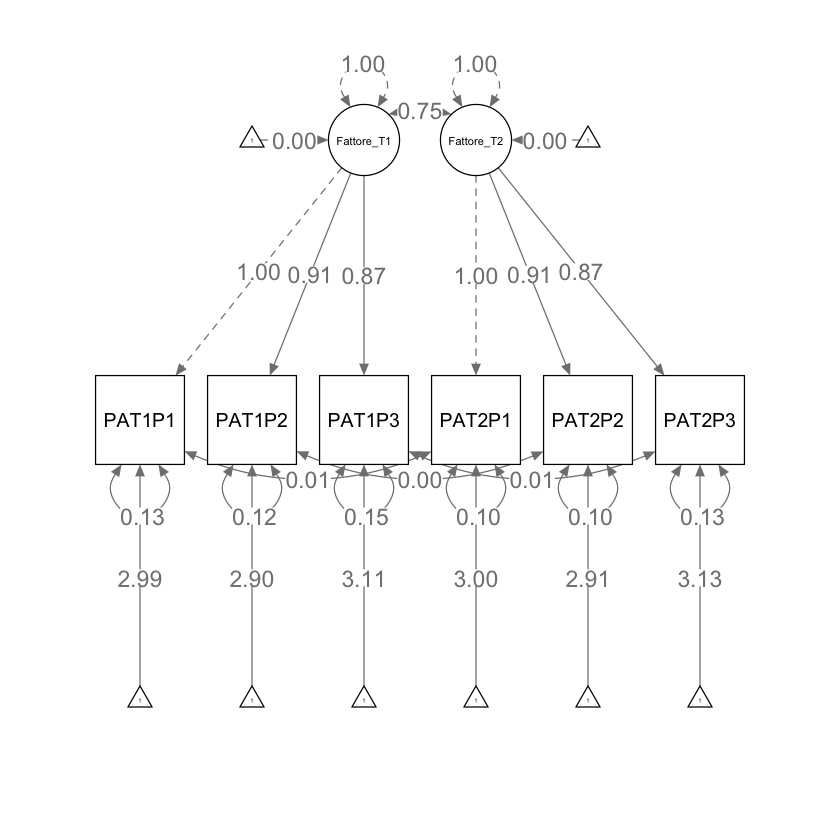

In [52]:
semPaths(fit_1,
    whatLabels = "est",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

Definiamo il modello di invarianza fattoriale forte (Scalare) (Livello 2) e lo adattiamo ai dati. Per trasformare il modello in modo da implementare l'invarianza forte (scalare) di livello 2, dobbiamo imporre l'uguaglianza sia dei carichi fattoriali sia delle intercettazioni degli indicatori nei diversi momenti temporali. Questo significa che oltre ai carichi fattoriali, anche le intercette (o medie) degli indicatori devono essere considerate uguali tra i due momenti temporali (T1 e T2).

In [48]:
mod_2 <- "
  # Definizione dei fattori latenti al tempo T1 con carichi fattoriali e intercettazioni uguali a T2
  Fattore_T1 =~ a1*PAT1P1 + a2*PAT1P2 + a3*PAT1P3
  PAT1P1 ~ b1*1
  PAT1P2 ~ b2*1
  PAT1P3 ~ b3*1

  # Definizione dei fattori latenti al tempo T2 con carichi fattoriali e intercettazioni uguali a T1
  Fattore_T2 =~ a1*PAT2P1 + a2*PAT2P2 + a3*PAT2P3
  PAT2P1 ~ b1*1
  PAT2P2 ~ b2*1
  PAT2P3 ~ b3*1

  # Varianza dei fattori latenti
  Fattore_T1 ~~ 1*Fattore_T1
  Fattore_T2 ~~ 1*Fattore_T2

  # Covarianza tra i fattori latenti
  Fattore_T1 ~~ Fattore_T2

  # Definizione degli errori di misurazione per gli indicatori al tempo T1
  PAT1P1 ~~ PAT1P1
  PAT1P2 ~~ PAT1P2
  PAT1P3 ~~ PAT1P3

  # Definizione degli errori di misurazione per gli indicatori al tempo T2
  PAT2P1 ~~ PAT2P1
  PAT2P2 ~~ PAT2P2
  PAT2P3 ~~ PAT2P3

  # Covarianze tra i residui degli item tra T1 e T2
  PAT1P1 ~~ PAT2P1
  PAT1P2 ~~ PAT2P2
  PAT1P3 ~~ PAT2P3
"

In [49]:
fit_2 <- lavaan::sem(mod_2, data = dat, meanstructure = TRUE)

In [50]:
parameterEstimates(fit_2) |> print()

,lhs,op,rhs,label,est,se,z,pvalue,ci.lower,ci.upper
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Fattore_T1,=~,PAT1P1,a1,1.000000000,0.000000000,NA,NA,1.000000000,1.00000000
2,Fattore_T1,=~,PAT1P2,a2,0.908619217,0.011901352,76.3458793,0.00000000,0.885292995,0.93194544
3,Fattore_T1,=~,PAT1P3,a3,0.868372448,0.012306068,70.5645747,0.00000000,0.844252998,0.89249190
4,PAT1P1,~1,,b1,2.996636108,0.033713196,88.8861478,0.00000000,2.930559458,3.06271276
5,PAT1P2,~1,,b2,2.902451093,0.030777324,94.3048556,0.00000000,2.842128646,2.96277354
6,PAT1P3,~1,,b3,3.119758229,0.029828528,104.5897480,0.00000000,3.061295389,3.17822107
7,Fattore_T2,=~,PAT2P1,a1,1.000000000,0.000000000,NA,NA,1.000000000,1.00000000
8,Fattore_T2,=~,PAT2P2,a2,0.908619217,0.011901352,76.3458793,0.00000000,0.885292995,0.93194544
9,Fattore_T2,=~,PAT2P3,a3,0.868372448,0.012306068,70.5645747,0.00000000,0.844252998,0.89249190


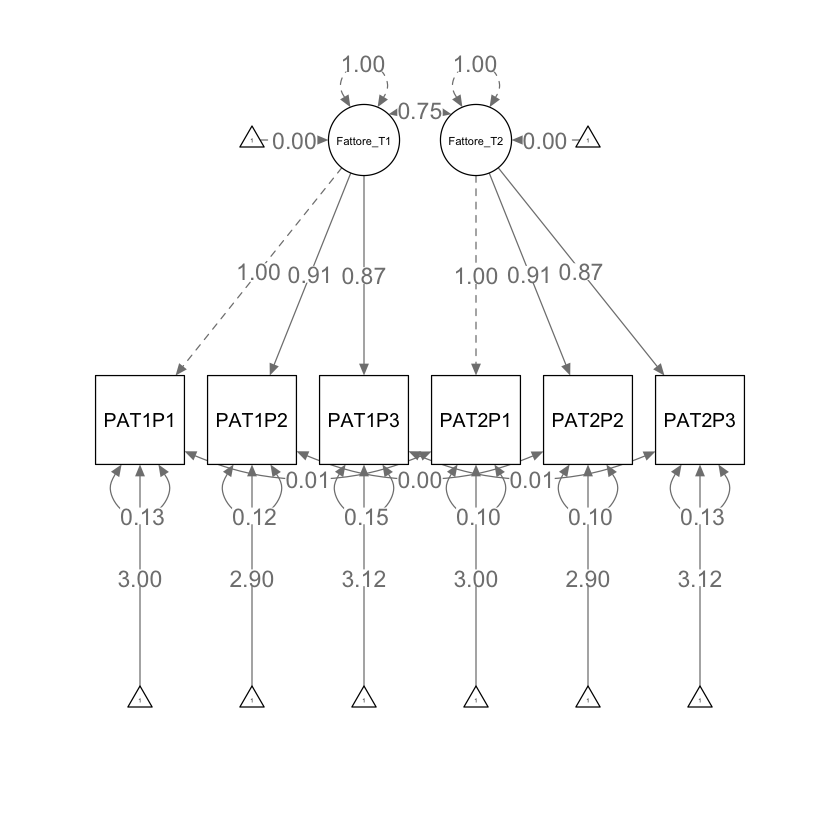

In [53]:
semPaths(fit_2,
    whatLabels = "est",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

Definiamo il modello di invarianza fattoriale rigorosa (Livello 3) e lo adattiamo ai dati. Per implementare l'invarianza fattoriale rigorosa (livello 3) nei modelli SEM longitudinali, oltre a mantenere l'uguaglianza dei carichi fattoriali e delle intercettazioni degli indicatori (come nel modello di invarianza forte), è necessario anche imporre l'uguaglianza delle varianze degli errori degli indicatori nei diversi momenti temporali.

In [54]:
mod_3 <- "
  # Definizione dei fattori latenti al tempo T1 con carichi fattoriali e intercettazioni uguali a T2
  Fattore_T1 =~ a1*PAT1P1 + a2*PAT1P2 + a3*PAT1P3
  PAT1P1 ~ b1*1
  PAT1P2 ~ b2*1
  PAT1P3 ~ b3*1

  # Definizione dei fattori latenti al tempo T2 con carichi fattoriali e intercettazioni uguali a T1
  Fattore_T2 =~ a1*PAT2P1 + a2*PAT2P2 + a3*PAT2P3
  PAT2P1 ~ b1*1
  PAT2P2 ~ b2*1
  PAT2P3 ~ b3*1

  # Varianza dei fattori latenti
  Fattore_T1 ~~ 1*Fattore_T1
  Fattore_T2 ~~ 1*Fattore_T2

  # Covarianza tra i fattori latenti
  Fattore_T1 ~~ Fattore_T2

  # Definizione delle varianze degli errori di misurazione per gli indicatori, uguali tra T1 e T2
  PAT1P1 ~~ d1*PAT1P1
  PAT1P2 ~~ d2*PAT1P2
  PAT1P3 ~~ d3*PAT1P3
  PAT2P1 ~~ d1*PAT2P1
  PAT2P2 ~~ d2*PAT2P2
  PAT2P3 ~~ d3*PAT2P3
"

In [55]:
fit_3 <- lavaan::sem(mod_3, data = dat, meanstructure = TRUE)

In [56]:
parameterEstimates(fit_3) |> print()

,lhs,op,rhs,label,est,se,z,pvalue,ci.lower,ci.upper
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Fattore_T1,=~,PAT1P1,a1,1.0000000,0.000000000,NA,NA,1.00000000,1.0000000
2,Fattore_T1,=~,PAT1P2,a2,0.9112184,0.011622992,78.39792,0,0.88843780,0.9339991
3,Fattore_T1,=~,PAT1P3,a3,0.8729148,0.011939497,73.11152,0,0.84951378,0.8963157
4,PAT1P1,~1,,b1,2.9967565,0.033630202,89.10908,0,2.93084250,3.0626705
5,PAT1P2,~1,,b2,2.9022930,0.030866091,94.02852,0,2.84179655,2.9627894
6,PAT1P3,~1,,b3,3.1195440,0.029898642,104.33731,0,3.06094370,3.1781442
7,Fattore_T2,=~,PAT2P1,a1,1.0000000,0.000000000,NA,NA,1.00000000,1.0000000
8,Fattore_T2,=~,PAT2P2,a2,0.9112184,0.011622992,78.39792,0,0.88843780,0.9339991
9,Fattore_T2,=~,PAT2P3,a3,0.8729148,0.011939497,73.11152,0,0.84951378,0.8963157


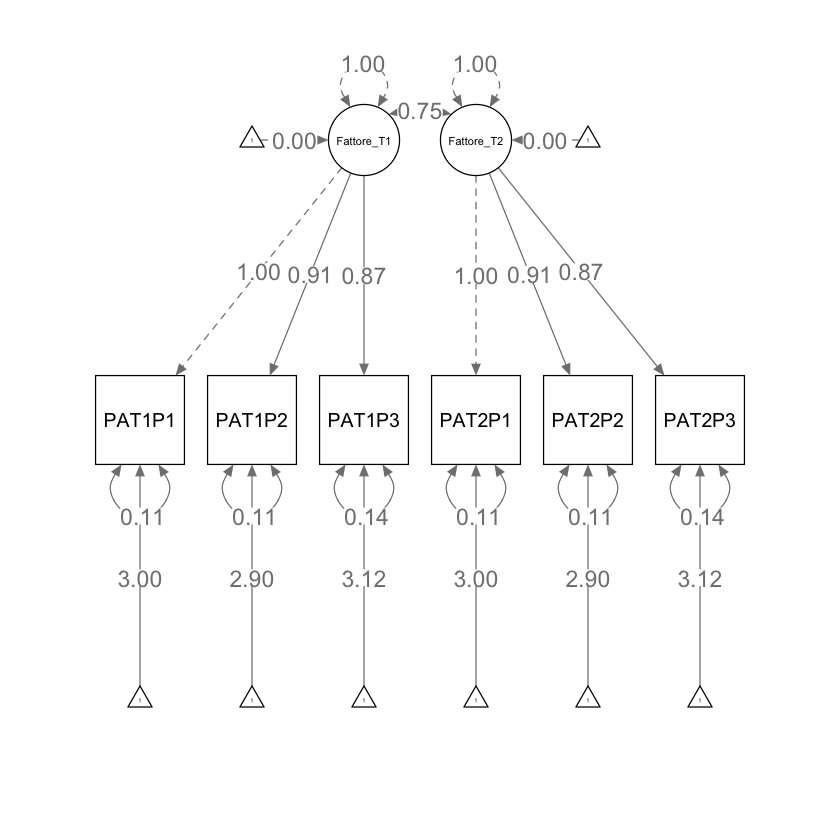

In [57]:
semPaths(fit_3,
    whatLabels = "est",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

Indici di fit per il livello 0:

In [66]:
fitMeasures(fit_0, c("chisq", "df", "cfi", "tli", "rmsea", "srmr")) |> print()

chisq    df   cfi   tli rmsea  srmr 
6.065 5.000 1.000 0.999 0.016 0.010 


Indici di fit per il livello 1:

In [67]:
fitMeasures(fit_1, c("chisq", "df", "cfi", "tli", "rmsea", "srmr")) |> print()

  chisq      df     cfi     tli   rmsea    srmr 
218.564   9.000   0.944   0.907   0.168   0.645 


Indici di fit per il livello 2:

In [68]:
fitMeasures(fit_2, c("chisq", "df", "cfi", "tli", "rmsea", "srmr")) |> print()

  chisq      df     cfi     tli   rmsea    srmr 
218.892  12.000   0.945   0.931   0.145   0.645 


Indici di fit per il livello 3:

In [69]:
fitMeasures(fit_3, c("chisq", "df", "cfi", "tli", "rmsea", "srmr")) |> print()

  chisq      df     cfi     tli   rmsea    srmr 
249.876  18.000   0.938   0.949   0.125   0.651 


Eseguiamo ora il confronto tra modello usando il test del rapporto tra verosimiglianze. Il test LRT confronta coppie di modelli per valutare se l'aggiunta di vincoli (come l'uguaglianza dei carichi o delle intercettazioni) peggiora significativamente l'adattamento del modello ai dati. 

fit_0: Modello di base (configurale).
fit_1: Modello con invarianza debole (metrica).
fit_2: Modello con invarianza forte (scalare).
fit_3: Modello con invarianza rigorosa.

In [75]:
lavTestLRT(fit_0, fit_1, fit_2, fit_3) |> print()


Chi-Squared Difference Test

      Df    AIC    BIC    Chisq Chisq diff    RMSEA Df diff Pr(>Chisq)    
fit_0  5 7427.8 7531.4   6.0645                                           
fit_1  9 7632.3 7717.1 218.5642    212.500 0.251665       4  < 2.2e-16 ***
fit_2 12 7626.6 7697.3 218.8920      0.328 0.000000       3     0.9547    
fit_3 18 7645.6 7688.0 249.8762     30.984 0.071131       6  2.553e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Passando dal modello **fit_0** al modello **fit_1**, si osserva un peggioramento significativo dell'adattamento del modello (p-value < 0.05), indicando che l'ipotesi di invarianza debole non è sostenuta dai dati. Ciò implica che, per questi dati specifici, l'unica forma di invarianza supportata è quella configurale. La validità del modello configurale è ulteriormente confermata dagli indici di adattamento, che risultano appropriati per questo livello di invarianza ma non per i livelli successivi di invarianza metrica, scalare e rigorosa.

In pratica, ciò significa che, basandoci sui dati a disposizione, non possiamo concludere che sia stato misurato lo stesso costrutto nelle due diverse occasioni di misurazione. Di conseguenza, un confronto diretto delle medie dei punteggi ottenuti nelle due diverse rilevazioni temporali non sarebbe giustificato. I risultati indicano che, sebbene i due momenti condividano un'invarianza configurale, cioè una somiglianza qualitativa nella struttura di base del modello, non sono abbastanza simili in termini quantitativi per permettere confronti validi. Questo suggerisce che nei due momenti temporali potrebbero essere stati misurati costrutti diversi, o almeno costrutti che non mantengono una costanza nelle loro relazioni quantitative nel tempo.

## Considerazioni Conclusive 

In questo capitolo, abbiamo esplorato in modo approfondito il modello CFA longitudinale. Questo modello è fondamentale per valutare la consistenza e l'affidabilità delle misurazioni nel tempo. Uno degli aspetti chiave trattati è stata l'invarianza fattoriale, un concetto cruciale che garantisce che i costrutti analizzati siano misurati in modo omogeneo e comparabile nelle diverse occasioni di misurazione. L'importanza dell'invarianza fattoriale non può essere sottolineata abbastanza, poiché garantisce che le modifiche rilevate nei costrutti nel tempo siano attribuibili a veri cambiamenti nei fenomeni in esame, piuttosto che a variazioni nelle modalità di misurazione o ad altri fattori confondenti.

Oltre alla valutazione dell'invarianza, il modello CFA longitudinale offre anche la possibilità di testare ipotesi semplici e di fornire informazioni descrittive sui cambiamenti nei costrutti nel corso del tempo. Questo può includere, ad esempio, l'analisi delle tendenze di sviluppo di determinati tratti o comportamenti, l'effetto di interventi nel tempo o la relazione tra variabili in diversi momenti.